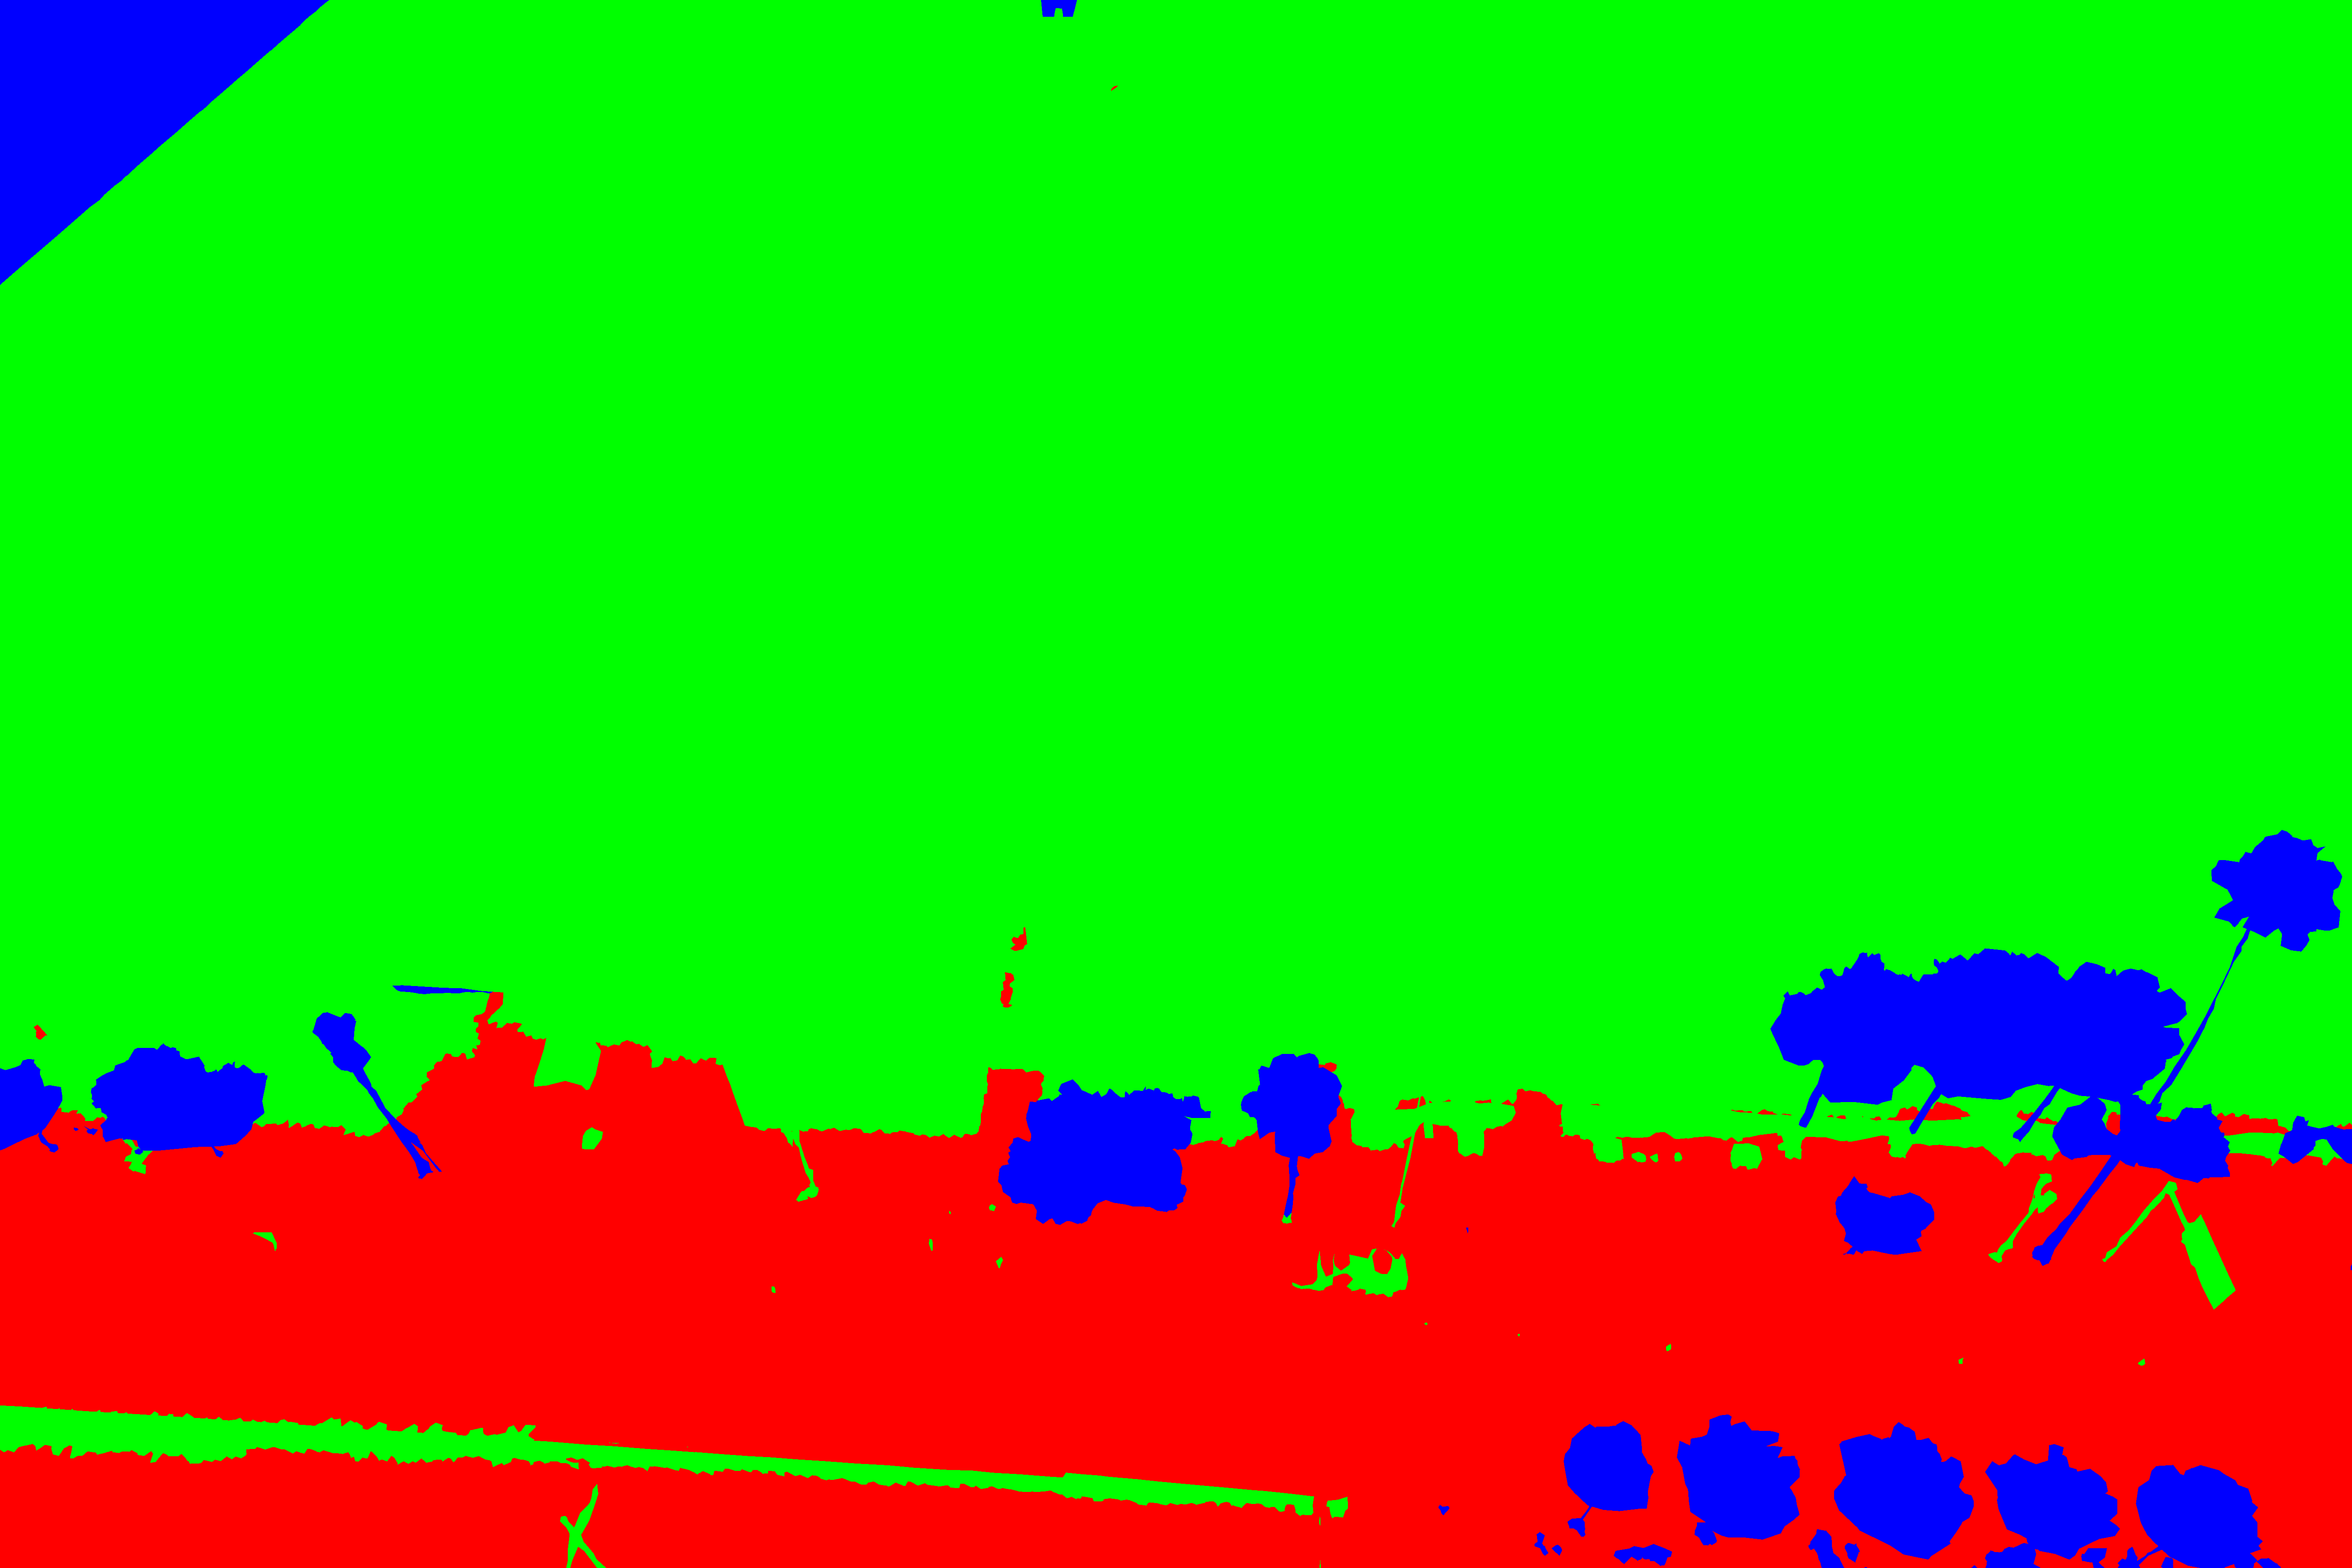

In [8]:
import numpy as np
import io
from PIL import Image

def convert_to_onehot(segmentation, n_labels=3):
    flatseg = np.ravel(segmentation)
    onehot = np.zeros((flatseg.size, n_labels), dtype=np.bool)
    onehot[np.arange(flatseg.size), flatseg] = True
    onehot = onehot.reshape(segmentation.shape + (n_labels,)).astype(int)
    return onehot.astype(np.float32)

sample_path = "/home/ICT2000/chenh/Haiwei/Datasets/OWT/USC_Galen_Center/DJI_0069.JPG"
seg_path = sample_path.replace('JPG','npy')

image = Image.open(sample_path)
seg = np.load(seg_path)
seg = np.uint8(convert_to_onehot(seg) * 255) 
seg_image = Image.fromarray(seg)

display(seg_image)

In [3]:
import torch

# device = torch.cuda.device(0)
device = torch.device('cuda:0')
# eval testing

# load config for transformer
from omegaconf import OmegaConf
# config_path = "configs/owt_transformer.yaml"
config_path = "logs/2022-08-02T07-32-14_usc_512_transformer/configs/2022-08-02T07-32-14-project.yaml"
config = OmegaConf.load(config_path)
import yaml
import torch.nn.functional as F
# print(yaml.dump(OmegaConf.to_container(config)))

config ['data']['params']['batch_size'] = 1
config['data']['params']['train']['params']['dataroot'] = "/home/ICT2000/chenh/Datasets/USC_Galen_Center"

unconditional = config.model.params.cond_stage_config == "__is_unconditional__"

In [2]:
# instantiate model
from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params).to(device)

# loading checkpoint
import torch
ckpt_path = "logs/2022-08-02T07-32-14_usc_512_transformer/checkpoints/last.ckpt"
sd = torch.load(ckpt_path, map_location=device)["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)
seg_model = config.model.params.first_stage_config.params.image_key == 'segmentation'

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from /home/ICT2000/chenh/taming-transformers/logs/2022-07-29T18-06-46_usc_512_pretrained_vggan/checkpoints/last.ckpt
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from /home/ICT2000/chenh/taming-transformers/logs/2022-08-01T01-35-19_usc_512_cond_stage/checkpoints/last.ckpt


In [ ]:
seg_model

In [ ]:
unconditional

In [4]:
# dataset instantiation
import importlib
from torch.utils.data import random_split, DataLoader, Dataset

def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))


def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

data = instantiate_from_config(config.data)
data.prepare_data()
data.setup()
dataset = data.datasets['train']
dataset_iter = iter(data._train_dataloader())


ImgToPath: 0it [00:00, ?it/s]
ImgToPath: 0it [00:00, ?it/s]


ValueError: num_samples should be a positive integer value, but got num_samples=0

dict_keys(['image', 'segmentation', 'img_path', 'seg_path', 'filename_'])


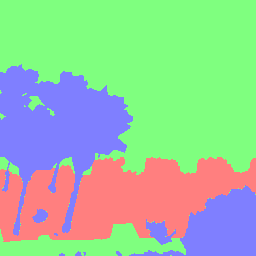

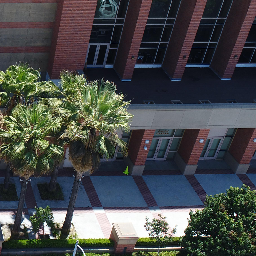

[1, 256, 16, 16] [1, 256]


In [29]:
from PIL import Image
import numpy as np
import cv2

import torch.nn.functional as F

idx = 5
batch = dataset[idx]
print(batch.keys())

tensify = lambda x: torch.from_numpy(x[None]).to(device).permute(0,3,1,2).contiguous().float()
tensor_to_numpy = lambda x:x.detach().cpu().numpy()[0].transpose(1,2,0)

def write_images(path, image, n_row=1):
    image = ((image + 1) * 255 / 2).astype(np.uint8)
    if image.ndim == 3:
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGRA)
    cv2.imwrite('{}'.format(str(path)), np.squeeze(image))

def show_image(s, iftorch=False):
  if iftorch:
    s = s.detach().cpu().numpy()[0]
  s = ((s + 1) * 255 / 2).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)
    
segmentation = batch['segmentation']
show_image(segmentation)

image = batch['image']
show_image(image)
# write_images('test.png',image)
# write_images('test_seg.png',segmentation)

# initialize some params
mask = 1.0
mask_tensor = None
nb = 1 #c_code.shape[0]
codebook_size = config.model.params.first_stage_config.params.embed_dim
# z_indices_shape = c_indices.shape
c_code_res = 16
res = 256
c_code_res = int(res**0.5)
z_indices_shape = [nb,res]
z_code_shape = [nb, codebook_size,c_code_res,c_code_res]
print(z_code_shape, z_indices_shape)


In [ ]:
# (caution! slow execution) (optional) batch image of the original size
image_path = dataset[idx]['img_path']
full_image = Image.open(image_path)
full_img = np.array(full_image).astype(np.float32) 
full_img = (img/127.5 - 1.0)
show_image(full_img)

In [ ]:
# (optional) sample random indices to image VQQGAN
# z_code_shape = codebook_size
z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)
print(z_indices.shape)
x_sample = model.decode_to_img(z_indices, z_code_shape)
print(x_sample.shape)
if seg_model:
    x_sample = F.softmax(x_sample,dim=1)
show_image(tensor_to_numpy(x_sample), False)

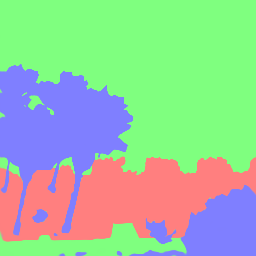

In [30]:
# conditional model or segmentation model
if not unconditional:
    # reconstructing seg tensor
    seg_tensor = tensify(segmentation)
    c_code, c_indices = model.encode_to_c(seg_tensor)
    seg_rec = model.cond_stage_model.decode(c_code)
    seg_rec = F.softmax(seg_rec,dim=1)
    show_image(tensor_to_numpy(seg_rec), False)
    
if seg_model:
    # reconstructing seg tensor
    seg_tensor = tensify(segmentation)
    c_code, c_indices = model.encode_to_z(seg_tensor)
    seg_rec = model.first_stage_model.decode(c_code)
    seg_rec = F.softmax(seg_rec,dim=1)
    show_image(tensor_to_numpy(seg_rec), False)

In [13]:
# inpainting testing: replace random z indices with that of an encoded batch image
key = 'segmentation' if seg_model else "image"
x = tensify(batch[key]) 
if unconditional:
    c = x
    quant_c, c_indices = model.encode_to_c(c)
else:
    c = tensify(batch['segmentation'])
    quant_c = c_code
# c = x if unconditional else tensify(batch['segmentation'])
quant_z, z_indices = model.encode_to_z(x)
# quant_c, c_indices = model.encode_to_c(c)
gt_z_indices = z_indices

In [31]:
## initialize some other params related to transformer
from IPython.display import clear_output
import time
import os

output_dir = os.path.join("logs", "eval", "notebook_vis")
os.makedirs(output_dir, exist_ok=True)

idx = z_indices
idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])

if not unconditional:
    cidx = c_indices
    cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])

temperature = 1.0
top_k = 100
update_every = 10

nx = z_code_shape[2]
ny = z_code_shape[3]

In [1]:
# inpainting testing: replace random z indices with that of an encoded batch image

MASK_LABEL = 1


key = 'segmentation' if seg_model else "image"
x = tensify(batch[key]) 
if unconditional:
    c = x
    quant_c, c_indices = model.encode_to_c(c)
else:
    c = tensify(batch['segmentation'])
    quant_c = c_code
# c = x if unconditional else tensify(batch['segmentation'])
quant_z, z_indices = model.encode_to_z(x)
# quant_c, c_indices = model.encode_to_c(c)
gt_z_indices = z_indices

# inpainting demo: masking out a certain region of the image
seg_label = np.argmax(segmentation, axis=2)
mask = (seg_label != MASK_LABEL).astype(np.float32)[...,None]
show_image(segmentation * mask)
show_image(image * mask)

# idx, cidx: codebook of the encoded image
mask_tensor = torch.from_numpy(mask).to(idx.device).float()
mask_tensor = mask_tensor.unsqueeze(0)[...,0]
mask_tensor = torch.nn.functional.interpolate(mask_tensor.unsqueeze(1), scale_factor=1/16)
mask_tensor = mask_tensor[:,0].int()
# print(mask_tensor.reshape(-1))
# print(mask_tensor.shape, idx.shape)

# mask idx 
idx = idx * mask_tensor

NameError: name 'seg_model' is not defined

Time: 6.156369686126709 seconds
Step: (0,0)


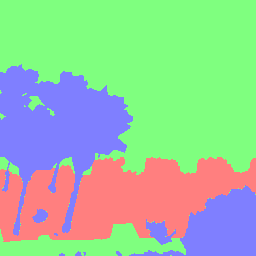

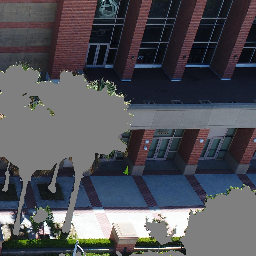

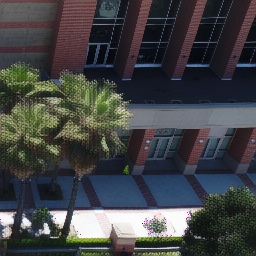

In [34]:
# generate a multiplied-scale scene with a large (partially fixed) random codebook
multiplier = 1
nnx = nx * multiplier
nny = ny * multiplier
c_code_res = 16
step_size = 8
no_mask = False
det = False

target_image = np.zeros([multiplier*256, multiplier*256, 3])
z_indices = torch.randint(codebook_size, [nb,(multiplier**2)*res], device=model.device)
z_indices = z_indices.reshape(nb, nnx, nny)

# (demo) masking gt_z_indices
if mask_tensor is not None:
    input_z_indices = gt_z_indices * mask_tensor.reshape(1, -1)
else:
    input_z_indices = gt_z_indices
    
# partially fill the z_indices with true data
z_indices[:,:nx, :ny] = input_z_indices.reshape(nb, nx, ny)
occupancy = np.zeros(z_indices.shape).astype(bool)

if no_mask:
    pass
elif mask_tensor is not None:
    occupancy[:,:nx, :ny] = mask_tensor.bool().detach().cpu().numpy()
else:
    occupancy[:,:nx, :ny] = True

start_t = time.time()

# outer loop: image to decode
for i in range(0, nnx - step_size, step_size):
    for j in range(0, nny - step_size, step_size):
        idx = z_indices[:, i:i+c_code_res, j:j+c_code_res].reshape(nb, -1)
        occ = occupancy[:, i:i+c_code_res, j:j+c_code_res].reshape(nb, -1)       
        # only update a block in idx if it is not occupied
        for ii in range(idx.shape[1]):
            if not occ[0,ii]:
                if unconditional:
                    patch = torch.cat((c_indices, idx[:,:ii]), dim=1)
                    logits,_ = model.transformer(patch)
                else:
                    cpatch = cidx[:, i:i+c_code_res, j:j+c_code_res].reshape(nb, -1)
                    # cpatch = cidx.reshape(nb, -1)
                    logits,_ = model.transformer(idx[:,:ii], cpatch)
                # patch = torch.cat((c_indices, idx[:,:ii]),1)
                # logits,_ = model.transformer(patch)
                logits = logits[:, -1, :]
                logits = logits/temperature
                if top_k is not None:
                  logits = model.top_k_logits(logits, top_k)
                probs = torch.nn.functional.softmax(logits, dim=-1)
                if det:
                    _, idx[:,ii] = torch.topk(probs, k=1, dim=-1)
                else:
                    idx[:,ii] = torch.multinomial(probs, num_samples=1)
                occ[:,ii] = True
        idx = idx.reshape(nb, c_code_res, c_code_res)
        occ = occ.reshape(nb, c_code_res, c_code_res)
        z_indices[:, i:i+c_code_res, j:j+c_code_res] = idx
        occupancy[:, i:i+c_code_res, j:j+c_code_res] = occ
        print(f"Time: {time.time() - start_t} seconds")
        print(f"Step: ({i},{j})")

new_z_code_shape = [nb, codebook_size, multiplier*16, multiplier*16]
x_sample = model.decode_to_img(z_indices, new_z_code_shape)
if seg_model:
    x_sample = F.softmax(x_sample, dim=1)
target_image = x_sample[0].detach().cpu().numpy().transpose(1,2,0)
show_image(segmentation)
show_image(image * mask)
show_image(target_image, False)

In [ ]:
for i in range(0, nnx, c_code_res):
    for j in range(0, nny, c_code_res):
        patch_code = z_indices[:, i:i+c_code_res, j:j+c_code_res]
        x_sample = model.decode_to_img(patch_code, z_code_shape)
        if seg_model:
            x_sample = F.softmax(x_sample, dim=1)
        patch_image = x_sample[0].detach().cpu().numpy().transpose(1,2,0)
        target_image[i*16:i*16+256, j*16:j*16+256] = patch_image
show_image(target_image, False)

In [ ]:
# generate the original scene with a known encoded codebook
update_every = 1000000000
multiplier = 1
quant_z, z_indices = model.encode_to_z(x)
idx = z_indices
idx = idx.reshape(z_code_shape[0], z_code_shape[2],z_code_shape[3])

nx = z_code_shape[2]
ny = z_code_shape[3]
start_t = time.time()

for i in range(0, nx-0):
  if i <= 8:
    local_i = i
  elif nx-i < 8:
    local_i = 16-(nx-i)
  else:
    local_i = 8
  for j in range(0,ny-0):
    if j <= 8:
      local_j = j
    elif ny-j < 8:
      local_j = 16-(ny-j)
    else:
      local_j = 8
    
    i_start = i-local_i
    i_end = i_start+16
    j_start = j-local_j
    j_end = j_start+16
    # print(i_start, i_end, j_start, j_end)
    patch = idx[:,i_start:i_end,j_start:j_end]
    patch = patch.reshape(patch.shape[0],-1)
    if unconditional:
        patch = torch.cat((c_indices, patch), dim=1)
        logits,_ = model.transformer(patch[:,:-1])
    else:
        cpatch = cidx[:, i_start:i_end, j_start:j_end]
        cpatch = cpatch.reshape(cpatch.shape[0], -1)
        # patch = torch.cat((cpatch, patch), dim=1)
        logits,_ = model.transformer(patch[:,:-1], cpatch)

    logits = logits[:, -256:, :]
    logits = logits.reshape(z_code_shape[0],16,16,-1)
    logits = logits[:,local_i,local_j,:]
    logits = logits/temperature
    
    if top_k is not None:
      logits = model.top_k_logits(logits, top_k)

    probs = torch.nn.functional.softmax(logits, dim=-1)
    idx[:,i,j] = torch.multinomial(probs, num_samples=1)

    step = i*z_code_shape[3]+j
    if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:
      x_sample = model.decode_to_img(idx, z_code_shape)
      clear_output()
      print(f"Time: {time.time() - start_t} seconds")
      print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
      print(x_sample.shape)
      if not unconditional:
          show_image(tensor_to_numpy(seg_rec), False)
      show_image(tensor_to_numpy(x_sample), False)
      # write_images(os.path.join(output_dir, f"step{step}_{i}_{j}.png"), tensor_to_numpy(x_sample))
      patch_output = tensor_to_numpy(x_sample)
